In [1]:
%matplotlib inline

In [2]:
import itertools
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.fft import rfft, rfftfreq
from scipy.signal import argrelmin
from tqdm.notebook import tqdm

In [3]:
from types import SimpleNamespace

import scipy.constants

###################################################################
# Units
# Length : nm
# Energy : meV
# Current : nA
# Temperature : K

constants = SimpleNamespace(
    hbar=scipy.constants.hbar,
    m_e=scipy.constants.m_e,
    eV=scipy.constants.eV,
    e=scipy.constants.e,
    meV=scipy.constants.eV * 1e-3,
    k_B=scipy.constants.k / (scipy.constants.eV * 1e-3),
    mu_B=scipy.constants.physical_constants["Bohr magneton"][0]
    / (scipy.constants.eV * 1e-3),
    current_unit=scipy.constants.k * scipy.constants.e / scipy.constants.hbar * 1e9,
)

In [4]:
plt.style.use("../../sans_style.mplstyle")
plt.close("all")


pd_cmap = mpl.colors.ListedColormap(
    ["darkorange", "gold", "lightgreen", "lightseagreen"]
)
line_colors = [
    "xkcd:bright sky blue",
    "xkcd:cobalt blue",
    "xkcd:bright purple",
    "xkcd:bordeaux",
]


def add_label(ax, text, position="tl", color=[1, 1, 1, 0.90]):
    if position=="tl":
        ax.text(
            0.03,
            0.96,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=5,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    elif position=='tr':
        ax.text(
            0.65,
            0.96,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=5,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    elif position=='bl':
        ax.text(
            0.03,
            0.1,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=5,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    elif position=='br':
        ax.text(
            0.65,
            0.1,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=5,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    else:
        pass

In [5]:
simname = "Fig4_open2"

a_label = r"$h_\mathrm{lat} / \Delta$"
b_label = r"$h_C / \Delta$"

Delta_0 = 0.250
a_scale = Delta_0
b_scale = Delta_0

In [6]:
ds = xr.open_dataset(f"./output/{simname}/{simname}.nc")

ws = ds["ws"]
a_N, b_N, theta_N, k = ws.shape

a_ax = ds.coords["a"].to_numpy()
b_ax = ds.coords["b"].to_numpy()

a, b = np.meshgrid(a_ax, b_ax, indexing="ij")

theta_ax = ds.coords["theta"].to_numpy()
theta_N = theta_ax.shape[0]
dtheta = theta_ax[1] - theta_ax[0]

In [7]:
def logcosh(x):
    ax = np.abs(x)
    return ax if ax > 2 else np.log(2 * np.cosh(x))


logcosh = np.frompyfunc(logcosh, 1, 1)

In [8]:
# Set the temperature
T = 20e-3  # mK

f = -(constants.k_B * T) * logcosh(ws / (2 * constants.k_B * T))
F = np.sum(f, axis=-1)

F.name = "F"

In [9]:
arm = argrelmin(F.to_numpy(), axis=-1, order=1, mode="wrap")

mins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]
vmins_list = [[[] for _ in range(b_N)] for __ in range(a_N)]

for n in range(len(arm[0])):
    i = arm[0][n]
    j = arm[1][n]
    n = arm[2][n]

    mins_list[i][j].append(theta_ax[n])
    vmins_list[i][j].append(F[i, j, n])

In [10]:
pd = np.zeros((a_N, b_N)) * np.nan
pdm = np.zeros((a_N, b_N)) * np.nan
pdf = np.zeros((a_N, b_N)) * np.nan

for i, j in tqdm(np.ndindex(a_N, b_N), total=a_N * b_N):

    if len(mins_list[i][j]) == 1:
        if abs(mins_list[i][j][0]) < abs(mins_list[i][j][0] - np.pi):
            pd[i][j] = 0
        else:
            pd[i][j] = 3.14

    elif len(mins_list[i][j]) == 2:
        vmmin = np.argmin(vmins_list[i][j])
        mmin = mins_list[i][j][vmmin]

        if abs(mmin) < abs(mmin - np.pi):
            pd[i][j] = 3.14 / 3
        else:
            pd[i][j] = 2 * 3.14 / 3

    else:
        pd[i][j] = np.mean(mins_list[i][j])
    pdm[i][j] = np.mean(mins_list[i][j])
    pdf[i][j] = mins_list[i][j][0]

  0%|          | 0/6561 [00:00<?, ?it/s]

In [11]:
_I = (np.roll(F.to_numpy(), -1, axis=-1) - F.to_numpy()) / dtheta
_I *= 2 * constants.e / constants.hbar * constants.meV * 1e9

_I_c = np.zeros((a_N, b_N))
for i, j in np.ndindex(a_N, b_N):
    _I_c[i, j] = _I[i, j, np.argmax(np.abs(_I[i, j, : theta_N // 2]), axis=-1)]

I = xr.zeros_like(F)
I[:, :, :] = _I

I_c = xr.DataArray(_I_c, dims=("a", "b"), coords={"a": a_ax, "b": b_ax})

I_0 = 2 * constants.e * Delta_0 / constants.hbar * constants.meV * 1e9

In [12]:
N = F.shape[-1]

ks = rfftfreq(N, 1 / N)
F_k = 2.0 / N * rfft(F)
cF_k = +F_k.real
sF_k = -F_k.imag

/scratch/38070420/ipykernel_19005/356296343.py:64: RuntimeWarning: invalid value encountered in sqrt
  return gamma*(pm*np.sqrt(eps**2/gamma**2 + 4 * Delta_0**2/(Delta_0**2-h_l**2)*(1-T*np.sin(phi/2)**2)) - 2 * h_l/np.sqrt(Delta_0**2-h_l**2))


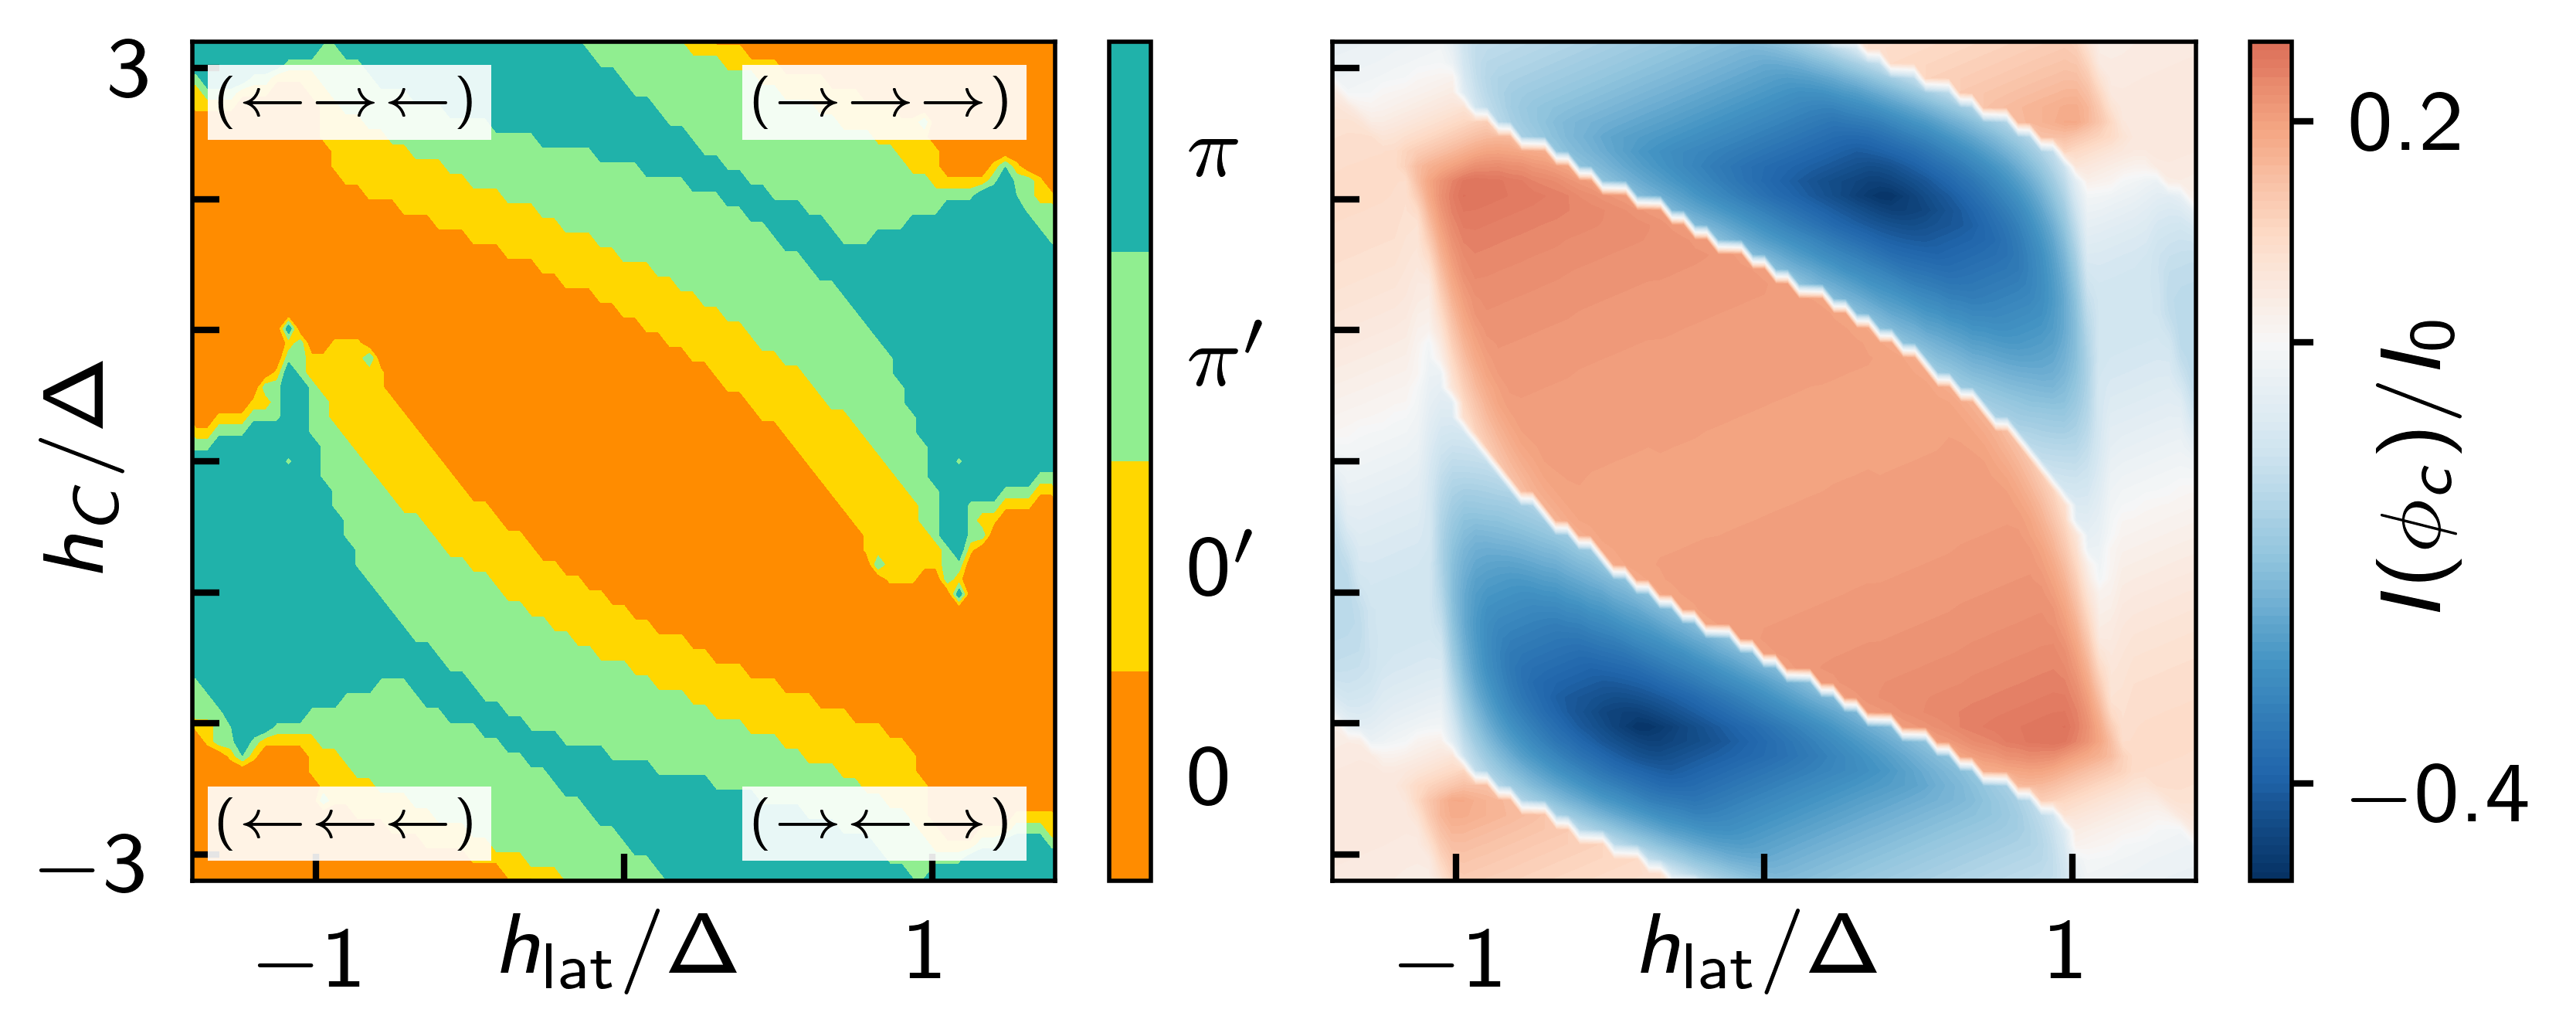

In [16]:
fig, (ax1, ax2) = plt.subplots(dpi=1000, figsize=(3.375, 3.375 * 0.4), ncols=2, nrows=1)

ax1.set_rasterization_zorder(0)
ax2.set_rasterization_zorder(0)
# ax3.set_rasterization_zorder(0)
# ax4.set_rasterization_zorder(0)

levels = np.linspace(0, 3.2, 5)

im = ax1.contourf(a / a_scale, b / b_scale, pd, levels=levels, cmap=pd_cmap, zorder=-30)

cbar1 = fig.colorbar(im, ax=ax1)
cbar1.set_ticks([1 / 8 * 3.2, 3 / 8 * 3.2, 5 / 8 * 3.2, 7 / 8 * 3.2])
cbar1.set_ticklabels([r"$0$", r"$0'$", r"$\pi'$", r"$\pi$"])
cbar1.ax.tick_params(length=0)

im = ax2.contourf(
    a / a_scale,
    b / b_scale,
    I_c / I_0,
    levels=100,
    norm=mpl.colors.CenteredNorm(),
    cmap="RdBu_r",
    zorder=-30,
)
cbar2 = fig.colorbar(im, ax=ax2)
cbar2.set_ticks(
    [np.around(I_c.min() / I_0, decimals=2), np.around(I_c.max() / I_0, decimals=2)]
)
cbar2.set_ticks([-0.4, 0, 0.2], labels=[r"$-0.4$", "", r"$0.2$"])
cbar2.ax.tick_params(length=2, direction="out")
cbar2.set_label(r"$I(\phi_c) / I_0$", labelpad=-15)

# im3 = ax3.contourf(
#     a / a_scale,
#     b / b_scale,
#     cF_k[:, :, 1] / Delta_0,
#     levels=100,
#     norm=mpl.colors.CenteredNorm(0),
#     cmap="PuOr_r",
#     zorder=-30,
# )
# cbar3 = fig.colorbar(im3, ax=ax3, format="%3.2f")
# cbar3.set_ticks([np.min(cF_k[:, :, 1] / Delta_0), np.max(cF_k[:, :, 1] / Delta_0)])
# cbar3.ax.tick_params(length=0)
# cbar3.set_label(r"$C_1 / \Delta$", labelpad=-15)

# im4 = ax4.contourf(
#     a / a_scale,
#     b / b_scale,
#     cF_k[:, :, 2] / Delta_0,
#     levels=100,
#     norm=mpl.colors.CenteredNorm(0),
#     cmap="PuOr",
#     zorder=-30,
# )
# cbar4 = fig.colorbar(im4, ax=ax4, format="%3.2f")
# cbar4.set_ticks([np.min(cF_k[:, :, 2] / Delta_0), np.max(cF_k[:, :, 2] / Delta_0)])
# cbar4.ax.tick_params(length=0)
# cbar4.set_label(r"$C_2 / \Delta$", labelpad=-15)


def hc(gamma, Delta_0, eps, h_l, phi, pm, T=1):
    return gamma*(pm*np.sqrt(eps**2/gamma**2 + 4 * Delta_0**2/(Delta_0**2-h_l**2)*(1-T*np.sin(phi/2)**2)) - 2 * h_l/np.sqrt(Delta_0**2-h_l**2))


h_l = np.linspace(-1.1, 1.1, 2001) * Delta_0

gamma = 0.3
eps = 0.0#24
T = 1.0

hc1p = hc(gamma, Delta_0, eps, h_l, 0, +1, T)
hc1m = hc(gamma, Delta_0, eps, h_l, 0, -1, T)
hc2p = hc(gamma, Delta_0, eps, h_l, np.pi/2, +1, T)
hc2m = hc(gamma, Delta_0, eps, h_l, np.pi/2, -1, T)
hc3p = hc(gamma, Delta_0, eps, h_l, np.pi/3, +1, T)
hc3m = hc(gamma, Delta_0, eps, h_l, np.pi/3, -1, T)

# ax1.plot(h_l/b_scale, hc1p/b_scale, '--k')
# ax1.plot(h_l/b_scale, hc1m/b_scale, '--k')
# ax1.plot(h_l/b_scale, hc2p/b_scale, '--k')
# ax1.plot(h_l/b_scale, hc2m/b_scale, '--k')
# ax1.plot(h_l/b_scale, hc3p/b_scale, '--k')
# ax1.plot(h_l/b_scale, hc3m/b_scale, '--k')

# ax2.plot(h_l/b_scale, hc1p/b_scale, '--k')
# ax2.plot(h_l/b_scale, hc1m/b_scale, '--k')
# ax2.plot(h_l/b_scale, hc2p/b_scale, '--k')
# ax2.plot(h_l/b_scale, hc2m/b_scale, '--k')
# ax2.plot(h_l/b_scale, hc3p/b_scale, '--k')
# ax2.plot(h_l/b_scale, hc3m/b_scale, '--k')


ax1.set_xticks([-1, 0, 1], labels=[r"$-1$", "", r"$1$"])
ax1.set_xlabel(a_label, labelpad=-8)
ax1.set_yticks(
    [-3, -2, -1, 0, 1, 2, 3], labels=[r"$-3$", r"", r"", r"", r"", r"", r"$3$"]
)
ax1.set_ylabel(b_label, labelpad=-8)

ax2.set_xticks([-1, 0, 1], labels=[r"$-1$", "", r"$1$"])
ax2.set_xlabel(a_label, labelpad=-8)
ax2.set_yticks(
    [-3, -2, -1, 0, 1, 2, 3], labels=[]
)
ax2.set_ylabel("")


ax1.set_xlim(-1.4, 1.4)
ax1.set_ylim(-3.2, 3.2)

ax2.set_xlim(-1.4, 1.4)
ax2.set_ylim(-3.2, 3.2)


add_label(ax1, r"$(\leftarrow \rightarrow \leftarrow)$", position="tl", color=[1, 1, 1, 0.90])
add_label(ax1, r"$(\rightarrow \rightarrow \rightarrow)$", position="tr", color=[1, 1, 1, 0.90])
add_label(ax1, r"$(\leftarrow \leftarrow \leftarrow)$", position="bl", color=[1, 1, 1, 0.90])
add_label(ax1, r"$(\rightarrow \leftarrow \rightarrow)$", position="br", color=[1, 1, 1, 0.90])

# add_label(ax2, r"$(\leftarrow \rightarrow \leftarrow)$", position="tl", color=[1, 1, 1, 0.90])
# add_label(ax2, r"$(\rightarrow \rightarrow \rightarrow)$", position="tr", color=[1, 1, 1, 0.90])
# add_label(ax2, r"$(\leftarrow \leftarrow \leftarrow)$", position="bl", color=[1, 1, 1, 0.90])
# add_label(ax2, r"$(\rightarrow \leftarrow \rightarrow)$", position="br", color=[1, 1, 1, 0.90])

fig.tight_layout(pad=0.5)
fig.savefig(f"{simname}.svg")